# Notebook 5b
After training several decision tree models for various sites and times of year, we are finding the brightness temperature thresholds to vary across time and space. This pattern appears to be loosely correlated to air temperatures. To further investigate, here we can train models by grouping time steps with similar air temperatures to create thresholds that can be extrapolated to other regions where we have fewer surface observations.

This will heavily mirror the methods used in Notebook 5a

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
path = '/storage/cdalden/goes/colorado/goes16/rgb_composite/'
file = 'rgb_tsi_east_river_202205_202305.csv'

rgb_tsi_df = pd.read_csv(path + file, index_col=0)
rgb_tsi_df.head()

,red,green,blue,cloud_binary
time,,,,
2022-05-01 14:02:30,0.667177,0.204012,0.128512,1.0
2022-05-01 14:07:30,0.600290,0.204620,0.114826,1.0
2022-05-01 14:12:30,0.590054,0.228038,0.133000,1.0
2022-05-01 14:17:30,0.623134,0.250853,0.164436,1.0
2022-05-01 14:32:30,0.435754,0.293231,0.151706,1.0


## Group times by air temperature

In [3]:
ds = xr.open_dataset('./met_30min.nc', engine='h5netcdf')
ds

/home/cdalden/miniforge3/envs/goes_env/lib/python3.13/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


<xarray.Dataset> Size: 3MB
Dimensions:                    (time: 31200)
Coordinates:
  * time                       (time) datetime64[ns] 250kB 2021-08-31T18:00:0...
Data variables: (12/20)
    org_precip_accum           (time) float32 125kB ...
    pwd_cumul_rain             (time) float32 125kB ...
    pwd_cumul_snow             (time) float32 125kB ...
    tbrg_precip_total          (time) float32 125kB ...
    tbrg_precip_total_corr     (time) float32 125kB ...
    atmos_pressure             (time) float32 125kB ...
    ...                         ...
    wdir_vec_mean              (time) float64 250kB ...
    pwd_err_code               (time) float64 250kB ...
    pwd_mean_vis_1min          (time) float64 250kB ...
    lat                        (time) float32 125kB ...
    lon                        (time) float32 125kB ...
    alt                        (time) float32 125kB ...
Attributes:
    units:      mm
    long_name:  Original Precipitation Accumulation

### Group timesteps by temp

In [4]:
airtemp_2m_c = ds.temp_mean.to_dataframe()
daily_avg_temp = airtemp_2m_c.groupby(airtemp_2m_c.index.date)['temp_mean'].mean()

# Convert the result to a new DataFrame
daily_avg_temp_df = daily_avg_temp.reset_index()
daily_avg_temp_df.columns = ['date', 'avg_temp']
# daily_avg_temp_df.set_index('date', inplace=True)

# Define the bin edges (e.g., -20°C to 10°C in 5°C intervals)
bin_edges = np.arange(-15, 20, 5)

# Add a 'bin' column to categorize 'avg_temp' into the defined bins
daily_avg_temp_df['bin'] = pd.cut(
    daily_avg_temp_df['avg_temp'], 
    bins=bin_edges, 
    labels=[f"{bin_edges[i]}C_to_{bin_edges[i+1]}C" for i in range(len(bin_edges)-1)],
    right=False  # Make bins left-inclusive
)
daily_avg_temp_df.dropna(inplace=True)


In [5]:
rgb_tsi_df.index = pd.to_datetime(rgb_tsi_df.index)

# Extract the date from the index of rgb_tsi_df
rgb_tsi_df['date'] = rgb_tsi_df.index.date


# Merge rgb_tsi_df with daily_avg_temp_df on the 'date' column
rgb_tsi_df = rgb_tsi_df.merge(daily_avg_temp_df[['date', 'bin']], on='date', how='left')

rgb_tsi_df.dropna(inplace=True)

In [6]:
for bin_value in rgb_tsi_df['bin'].unique():
    print(f"Processing bin: {bin_value}")

Processing bin: 0C_to_5C
Processing bin: -5C_to_0C
Processing bin: 5C_to_10C
Processing bin: 10C_to_15C
Processing bin: -10C_to_-5C
Processing bin: -15C_to_-10C


In [7]:
rgb_tsi_df_n15C_n10C = rgb_tsi_df.loc[rgb_tsi_df['bin']=='-15C_to_-10C']
rgb_tsi_df_n10C_n5C = rgb_tsi_df.loc[rgb_tsi_df['bin']=='-10C_to_-5C']
rgb_tsi_df_n5C_0C = rgb_tsi_df.loc[rgb_tsi_df['bin']=='-5C_to_0C']
rgb_tsi_df_0C_5C = rgb_tsi_df.loc[rgb_tsi_df['bin']=='0C_to_5C']
rgb_tsi_df_5C_10C = rgb_tsi_df.loc[rgb_tsi_df['bin']=='5C_to_10C']
rgb_tsi_df_10C_15C = rgb_tsi_df.loc[rgb_tsi_df['bin']=='10C_to_15C']

## Decision Tree Model

In [11]:
def train_tree(df, df_name):
    # Prepare the data
    X = df[['red', 'green', 'blue']].dropna()
    y = df['cloud_binary'].loc[X.index]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Train the decision tree classifier
    clf = DecisionTreeClassifier(max_depth=3, min_samples_split=10, class_weight='balanced', random_state=42)  # Limit depth for interpretability
    clf.fit(X_train, y_train)

    # Make predictions
    y_pred = clf.predict(X_test)

    # Print a detailed classification report
    print("\nClassification Report for {}:".format(df_name))
    print(classification_report(y_test, y_pred, target_names=['No Cloud', 'Cloud']))

    # Output the decision rules
    tree_rules = export_text(clf, feature_names=['red', 'green', 'blue'])
    print(tree_rules)

    # Print feature importance
    feature_importances = clf.feature_importances_
    for feature, importance in zip(['red', 'green', 'blue'], feature_importances):
        print(f"Feature: {feature}, Importance: {importance:.4f}")

    # Print the training and evaluation sample sizes
    print(f"Training sample size: {len(X_train)}")
    print(f"Evaluation sample size: {len(X_test)}")

In [12]:
for df_name, df in [
    ("rgb_tsi_df_n15C_n10C", rgb_tsi_df_n15C_n10C),
    ("rgb_tsi_df_n10C_n5C", rgb_tsi_df_n10C_n5C),
    ("rgb_tsi_df_n5C_0C", rgb_tsi_df_n5C_0C),
    ("rgb_tsi_df_0C_5C", rgb_tsi_df_0C_5C),
    ("rgb_tsi_df_5C_10C", rgb_tsi_df_5C_10C),
    ("rgb_tsi_df_10C_15C", rgb_tsi_df_10C_15C)
]:
    train_tree(df, df_name)


Classification Report for rgb_tsi_df_n15C_n10C:
              precision    recall  f1-score   support

    No Cloud       0.98      0.94      0.96       432
       Cloud       0.87      0.94      0.90       165

    accuracy                           0.94       597
   macro avg       0.92      0.94      0.93       597
weighted avg       0.95      0.94      0.94       597

|--- blue <= 0.13
|   |--- blue <= 0.11
|   |   |--- red <= 0.41
|   |   |   |--- class: 0.0
|   |   |--- red >  0.41
|   |   |   |--- class: 0.0
|   |--- blue >  0.11
|   |   |--- red <= 0.51
|   |   |   |--- class: 0.0
|   |   |--- red >  0.51
|   |   |   |--- class: 1.0
|--- blue >  0.13
|   |--- red <= 0.40
|   |   |--- green <= 0.46
|   |   |   |--- class: 1.0
|   |   |--- green >  0.46
|   |   |   |--- class: 0.0
|   |--- red >  0.40
|   |   |--- red <= 0.42
|   |   |   |--- class: 1.0
|   |   |--- red >  0.42
|   |   |   |--- class: 1.0

Feature: red, Importance: 0.2098
Feature: green, Importance: 0.0357
Featu

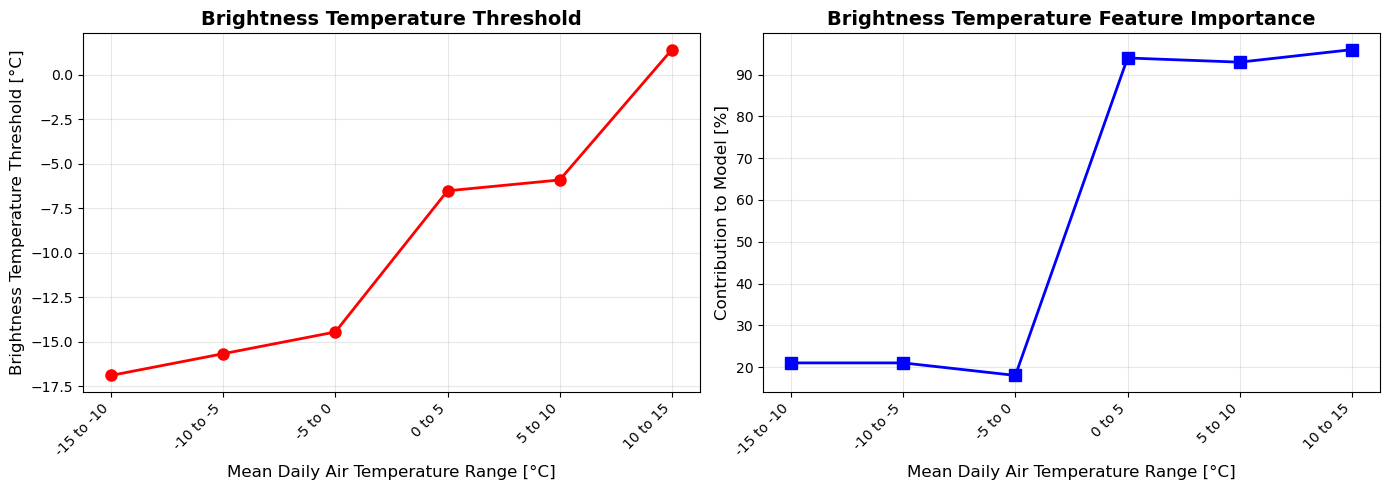

In [4]:
# Data from the table
temp_ranges = ['-15 to -10', '-10 to -5', '-5 to 0', '0 to 5', '5 to 10', '10 to 15']
red_threshold = [0.40, 0.38, 0.36, 0.23, 0.22, 0.10]
temperature_thresholds = 7.5 + np.array(red_threshold) * (-53.5 - 7.5)
red_feature_importance = [0.21, 0.21, 0.18, 0.94, 0.93, 0.96]
red_feature_importance_percent = [value * 100 for value in red_feature_importance]

# green_feature_importance = [0.04, 0.07, 0.08, 0.94, 0.93, 0.96]
# green_feature_importance_percent = [value * 100 for value in red_feature_importance]

# blue_feature_importance = [0.75, 0.72, 0.76, 0.94, 0.93, 0.96]
# blue_feature_importance_percent = [value * 100 for value in red_feature_importance]

temp_midpoints = [-12.5, -7.5, -2.5, 2.5, 7.5, 12.5]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Red Threshold vs Temperature Range
ax1.plot(temp_midpoints, temperature_thresholds, marker='o', linewidth=2, markersize=8, color='red')
ax1.set_xlabel('Mean Daily Air Temperature Range [°C]', fontsize=12)
ax1.set_ylabel('Brightness Temperature Threshold [°C]', fontsize=12)
ax1.set_title('Brightness Temperature Threshold', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(temp_midpoints)
ax1.set_xticklabels(temp_ranges, rotation=45, ha='right')

# Plot 2: Feature Importance vs Temperature Range
ax2.plot(temp_midpoints, red_feature_importance_percent, marker='s', linewidth=2, markersize=8, color='blue')
ax2.set_xlabel('Mean Daily Air Temperature Range [°C]', fontsize=12)
ax2.set_ylabel('Contribution to Model [%]', fontsize=12)
ax2.set_title('Brightness Temperature Feature Importance', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(temp_midpoints)
ax2.set_xticklabels(temp_ranges, rotation=45, ha='right')

plt.tight_layout()
plt.savefig('./btemp_thresholds_and_importance.png', dpi=300)